# Conditional Random Field implementation
## Using small number of demonstrations, no adversarial data
### Basic features --  not very descriptive

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import gym
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics


Bad key "text.kerning_factor" on line 4 in
/home/brendanjcrowe/anaconda3/envs/seq/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Load Expert Data 

In [2]:
# Load the expert data
data = pd.read_table(
    'mountain_car_demo.txt',
    sep=' ',
    header=0,
    names=['pos', 'vel', 'action', 'reward'],
    skiprows=1,
    index_col=False
)
data

,pos,vel,action,reward
0,-0.422633,-0.001758,0.0,-1.0
1,-0.426137,-0.003504,0.0,-1.0
2,-0.431361,-0.005225,0.0,-1.0
3,-0.438269,-0.006908,0.0,-1.0
4,-0.446809,-0.008541,0.0,-1.0
...,...,...,...,...
1247,0.344660,0.035769,2.0,-1.0
1248,0.380151,0.035491,2.0,-1.0
1249,0.415599,0.035448,2.0,-1.0
1250,0.451251,0.035652,2.0,-1.0


### Visualize data

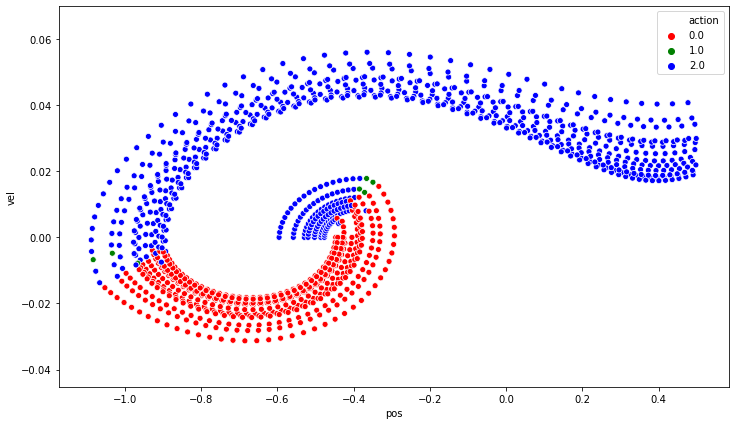

In [3]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data.pos, data.vel, hue=data.action, palette=['red', 'green', 'blue' ])

### Transform Data into a set of sequences

In [17]:
demos = [
    [0, 84],
    [85, 190],
    [191, 293],
    [294, 398],
    [399, 487],
    [488, 591],
    [592, 693],
    [694, 777],
    [778, 867],
    [868, 954],
    [955, 1057],
    [1058, 1146],
    [1147, 1251]
]
seqs = []

for k, demo in enumerate(demos):
    
    seqs.append(
        [
            [
                data.pos[i],
                data.vel[i],
                str(data.action[i])
            ]
            for i in range(demo[0], demo[1]+1)
        ]
    )
actions = [0, 1, 2]
position = [False, True]
velocity = [False, True]

In [18]:
def feats(seq, k):
    
    return {
            'position': seq[k-1][0] > seq[k][0] if k > 0 else False,
            'velocity': seq[k-1][1] > seq[k][1] if k > 0 else False,
            'first': k == 0,
            'last': k == len(seq)-1,
            'bias': True
    }

def labs(seq, k):
    
    return seq[k][2]
    
def seq_to_feats(seq):
    
    return [feats(seq, k) for k in range(len(seq))]

def seq_to_labs(seq):
    
    return [labs(seq, k) for k in range(len(seq))]

X_train = [seq_to_feats(seq) for seq in seqs]
y_train = [seq_to_labs(seq) for seq in seqs]


In [19]:
type(X_train[0][0]['position'])

bool

In [20]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=1000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

/home/brendanjcrowe/anaconda3/envs/seq/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=True, all_possible_transitions=True,
    keep_tempfiles=None, max_iterations=1000)

In [32]:
y_hat = np.array([np.array(seq_hat, dtype=np.float64) for seq_hat in crf.predict(X_train)], dtype=object)

In [35]:
y_hat = np.array(np.hstack([np.array(seq_hat, dtype=np.float64) for seq_hat in crf.predict(X_train)]))

In [36]:
y_hat.shape

(1252,)

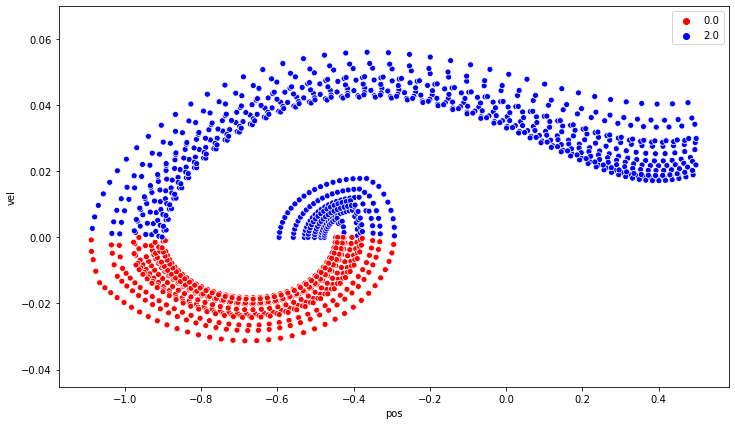

In [38]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data.pos, data.vel, hue=y_hat, palette=['red', 'blue' ])